# Data Visualization with Altair: a grammar of graphics for Python

In [1]:
import pandas as pd
import altair as alt
from pprint import pprint

In [2]:
url = "https://raw.githubusercontent.com/pabloinsente/pydata_altair_tutorial/master/data/diabetes_data.csv"
data = pd.read_csv(url)

In [3]:
data.shape

(101766, 51)

## Working with large datasets on Altair

Altair specification incorporates both the code AND the data **itself** in JSON format. This is why if you generate plots based on a large dataset, you will get a very large notebook (hundreds of MB or more), since the whole specification is embedded in the notebook itself. 

To prevent this to happen, Altair will through a MaxRowsError exception when you try to generate plots from datasets larger that 5000 rows. If this happens to you, there are three ways to get around it:

1. **Passing Data by URL**, such that the data is query from an external source
2. **Disabling MaxRowsError**, allowing Altair to embedd the data in the notebook
3. **Local Filesystem**, such that when you make a plot the data will be saved to disk, rather than being embedded in the notebook*
4. **Local Data Server**, such that your data is served from a local threaded server. The altair_data_server package provides this functionality*

*This may not work in certain cloud computing enviroments

More info: https://altair-viz.github.io/user_guide/faq.html

For instance, if we try to make a plot from our **101.766** rows dataset, we will get this error: 

In [4]:
chart = alt.Chart(data).mark_bar().encode(
     x='gender',
     y='num_medications'
)
chart

MaxRowsError: The number of rows in your dataset is greater than the maximum allowed (5000). For information on how to plot larger datasets in Altair, see the documentation

alt.Chart(...)

For now, we will allow to save a JSON object in our local filesystem. **Disabling the max rows is not recommended since working with large notebooks is slow and can crash your RAM**

In [5]:
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

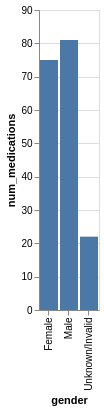

In [6]:
chart = alt.Chart(data).mark_bar().encode(
     x='gender',
     y='num_medications'
)
chart

Internally, Altair will generate a Vega-Lite specification in JSON format as follow

In [7]:
pprint(chart.to_dict())

{'$schema': 'https://vega.github.io/schema/vega-lite/v3.4.0.json',
 'config': {'mark': {'tooltip': None}, 'view': {'height': 300, 'width': 400}},
 'data': {'format': {'type': 'json'},
          'url': 'altair-data-83244b1bbbb518a7cb04402cb60362e2.json'},
 'encoding': {'x': {'field': 'gender', 'type': 'nominal'},
              'y': {'field': 'num_medications', 'type': 'quantitative'}},
 'mark': 'bar'}


The 'url' is linking to the JSON file saved locally, which normally would be saved in the notebook itself. We can inspect the JSON to see how it looks

At the end of your session, you can run ```!rm *json``` to avoid pushing large files to github

In [8]:
!rm *json

For the purposes of this tutorial we will take a sample of the larger dataset to work faster.

In [9]:
data_sample = data.sample(n=4000, replace=False, random_state=1)

We will use the race/ethnicity variable a lot, so we will select the main ones for clarity

In [10]:
groups = ['AfricanAmerican', 'Asian', 'Caucasian', 'Hispanic']
data_sample = data_sample[data_sample['race'].isin(groups)]

In [11]:
data_sample.shape

(3857, 51)

To delete the created objects and go back to default Altair functionality run:

In [12]:
del data 
del chart

In [13]:
alt.data_transformers.enable('default') # restore default for Altair

DataTransformerRegistry.enable('default')

## Unit specification: single cartesian chart or single view

A single cartesian Chart, also refered as sigle "view", describes a graphical object composed of a dataset, a mark type, and a set of encodings for visual channels such as color, size, position, etc.

### Strip plot of number of medications
- Here we create a basic Altair/Vega-Lite chart object as ```Chart(data)``` with data as argument
- Next, we chose to represent each record (row) as a tick mark ```mark_tick()```
- Finally, we encode the values in visual properties of the chart, in this case, as the x axis ```encode(x='num_medications')```

In [14]:
strip = alt.Chart(data_sample).mark_tick().encode(
     x='num_medications'
)
#strip

Altair/Vega-Lite will **automatically resolve any ambiguity** as the data type, lendend, and axis, by filling in with **sensible defaults**. This defaults are design to follow best practices on visualization design, and they can be overwritten as needed.

### Histogram of number of medications
- Altair/Vega-Lite it is not based on taxonomies of charts, yet, any chart can be generated by reasoning about the **underlying operations and elements** needed to create the chart
- For an histogram, we need to:
    - **Discretize** the data into bins
    - Encode the **aggregated count** of records within each bin as the y axis
    - Use a **'bar' as the geometric object** (mark) representing the aggregated data 

In [15]:
hist = alt.Chart(data_sample).mark_bar().encode(
    alt.X("num_medications:Q", bin=True),
    y='count()',
)
#hist

Altair/Vega-Lite allows to incrementaly customize our charts by maping value attributes to encoding channels. For instance, within each bin, we can encode race/ethnicity as a color attribute

In [16]:
hist1 = alt.Chart(data_sample).mark_bar().encode(
    alt.X("num_medications:Q", bin=True),
    y='count()',
    color='race:N'
)
# hist1

Here you can notice that Altair/Vega-Lite **automatically stacked the bars** to avoid overlapping them on top of each other. This is an example of the automatic selection of sensible defaults. We can see what would why stacking is better than overlapping by setting the stack to None.

In [17]:
hist2 = alt.Chart(data_sample).mark_bar(opacity=0.7).encode(
    alt.X("num_medications:Q", bin=True),
    alt.Y("count()", stack=None),
    color='race:N'
)
# hist2

He each bar is plotted on top of each other, so it is hard to appreciate the overall picture. Nevertheless, Altair/Vega-Lite **still selects nice defaults** by overlaying smaller bars on top of the larger ones.

### Heatmap of age group and race/ethnicity 
- To generate a heatmap we just need to map each variable to the right channels of the view:
    - x = variable 1
    - y = variable 2
    - a rectangle, as the geometric object representing data values
    - color, as a representation of some value aggregation (mean in this case)

In [18]:
heatmap = alt.Chart(data_sample).mark_rect().encode(
    x='age',
    y='race',
    color='mean(number_diagnoses)'
)
# heatmap

We can easily customize our heatmap by changing dimensions and color schemes.

In [19]:
dim = 300
heatmap1 = alt.Chart(data_sample).mark_rect().encode(
    x='age',
    y='race',
    color=alt.Color('mean(number_diagnoses)', scale=alt.Scale(scheme='goldred')),
).properties(
    width = dim,
    height= dim*0.4,
    )
# heatmap1

Many of the customization elements of Altair can be found in the Vega-Lite and Vega documentation. For instance, color schemes can be found here https://vega.github.io/vega/docs/schemes/

## Multiple unit specification: multiple Cartesian charts or composite view

A composite view describe the combination of multiple unit views (single charts) via **composition operators**. The for main composition operators are: **facet, repeat, layer, and concatenation**.

### Faceted chart

Faceted charts produces a trellis plot by sub-setting the data into subgroups. For quantitative variables scales and axes are shared by default. Facets are nice option for our histogram, since it makes clearer the distribution within each race/ethnicity.

In [20]:
base = alt.Chart(data_sample).mark_bar().encode(
    alt.X("num_medications:Q", bin=True),
    alt.Color('race:N', legend=None), # legends here are redundant
    y='count()'
).properties(
    width=180,
    height=180
)

facet_hist = base.facet(
    column='race:N'
)
# facet_hist

### Layered chart
Layering produces a view where charts are plotted on top of each other. In Altair/Vega-Lite this is achieved in two steps:
- Generate each plot independently
- Add them together with the "+" operator

In [21]:
bar = alt.Chart(data_sample).mark_bar().encode(
    x='mean(num_medications):Q',
    y='race:O',
    color=alt.Color('race:O', scale=alt.Scale(scheme='dark2'), legend=None),
)
# bar

In [22]:
rule = alt.Chart(data_sample).mark_rule(color='red').encode(
    x='mean(num_medications):Q'
)
# rule

In [23]:
layered = bar + rule
# layered

### Concatenated chart

The concat operattor "glue" together any type of view, vertically or horizontally

- Horizontal concatenation is useful when comparing different X axis values on the same Y values. In Altair we use the **"|"** operator
- Vertical concatenation is useful when comparing different Y axis values on the same X values. In Altair we use the **"&"** operator

In [24]:
bar2 = alt.Chart(data_sample).mark_bar().encode(
    x='mean(number_diagnoses):Q',
    y='race:O',
    color=alt.Color('race:O', scale=alt.Scale(scheme='dark2'), legend=None),
)
# bar2

In [25]:
hconcat = bar | bar2
# hconcat

In [26]:
bar3 = alt.Chart(data_sample).mark_bar().encode(
    x='mean(number_diagnoses):Q',
    y='gender:N',
    color=alt.Color('gender:N', scale=alt.Scale(scheme='dark2'), legend=None),
)
# bar3

In [27]:
vconcat = bar2 & bar3
# vconcat

### Repeated chart


The repeat operator generates multiple plots based on a list of encodings (e.g., column values). We can think in the repeat operator as a **more convenient/automated form of doing vertical/horizontal concatenation**. Essentially consolidate a recurrent use case for vertical and horizontal concatenation.

In [28]:
repeat = alt.Chart(data_sample).mark_bar().encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='nominal')
).properties(
    width=300,
    height=200
).repeat(
    row=['race', 'gender'],
    column=['number_diagnoses','num_medications'],
)
# repeat

In [29]:
repeat_color = alt.Chart(data_sample).mark_bar().encode(
    alt.X(alt.repeat("column"), type='quantitative', aggregate='mean'),
    alt.Y(alt.repeat("row"), type='nominal'),
    alt.Color(alt.repeat("row"), type='nominal', legend=None)
).properties(
    width=300,
    height=200
).repeat(
    row=['race', 'gender'],
    column=['number_diagnoses','num_medications']
)
# repeat_color

# TODO:
- Meta chart
- Interactivity